In [1]:
from brian2 import *
import numpy as np

In [2]:
N = 1
v_r = -70*mV # reset voltage
v_th = -55*mV  # threshold voltage
E_l = -90*mV
dia = 20*um
length = 20*um
SA = (2*pi*(dia/2)*length) # units are um2
gL = 1*psiemens/um2 * SA # units are psiemens
g_II = 40*psiemens/um2 * SA # units are psiemens...becomes 50 nsiemens
g_EE = 40*psiemens/um2 * SA # units are psiemens...becomes 50 nsiemens
we = 5*nsiemens  # excitatory synaptic weight
wi = 15*nsiemens # inhibitory synaptic weight
# g_EI = 24*psiemens/um2 * SA # units are psiemens
# g_IE = 8*psiemens/um2 * SA # units are psiemens
C_mem = 10e-6*farad/cm2 * SA # units are farad
E_ex = 0*mV
E_i = -80*mV 
v_c = 0*mV
I_c = 10 # same as I_ext, units pamp
tau_ge = 2*ms
tau_gi_c = 6.8 # units of ms
integ_method = 'heun'
run_time = 100*ms

# full model
model_0 = '''
dv/dt = (1/C_mem)*(ge*(v - E_ex) + gi*(v - E_i) + gL*(v - E_l) + I) : volt (unless refractory)
dge/dt = -ge/tau_ge : siemens
dgi/dt = -gi/tau_gi : siemens
I : ampere
tau_gi : second
'''

In [3]:
# implementing conductance in the synapse equations
# conductance equation format taken from https://brian2.readthedocs.io/en/2.0rc/examples/COBAHH.html

start_scope()
G3 = NeuronGroup(N, model_0, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method,name='neurongroup_3')
# G3.I = np.random.normal(I_c,1,1)*1000*pamp
G3.I = I_c*100*pamp
G3.ge = g_EE
G3.gi = g_II
# G3.tau_gi = np.random.normal(tau_gi_c, 1,1)*ms
G3.tau_gi = tau_gi_c*ms
G3.v = v_c
statemon3 = StateMonitor(G3, variables=['v','ge','gi'],record=0)
spikemon3 = SpikeMonitor(G3,variables='v')

G4 = NeuronGroup(N, model_0, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method,name='neurongroup_4')
# G4.I = np.random.normal(I_c,1,1)*pamp
G4.I = I_c*pamp
G4.ge = g_EE
G4.gi = g_II
# G4.tau_gi = np.random.normal(tau_gi_c, 1,1)/2*ms
G4.tau_gi = tau_gi_c*ms
G4.v = v_c
statemon4 = StateMonitor(G4, variables=['v','ge','gi'],record=0,dt=10*us)
spikemon4 = SpikeMonitor(G4,variables='v')

# Model equations follow setup in this link:
# https://brian2.readthedocs.io/en/stable/examples/COBAHH.html

# when the weight is positive, it's an excitatory connection so ge is increased while gi is allowed to continue its decay
# when the weight is negative, vice versa. 
S3 = Synapses(G3, G4, model ='''w : volt''', on_pre='''v_post += w
              ge+=we*(w>0*volt)
              gi+=wi*(w<0*volt)''')
S3.connect(i=0, j=0)

# positive weight for an excitatory connection, -ve weight for inhibitory
S3.w = 0.5*volt

run(run_time)

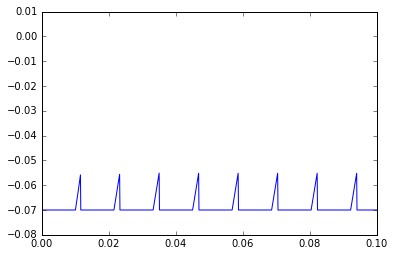

In [4]:
plot(statemon3.t,np.transpose(statemon3.v))

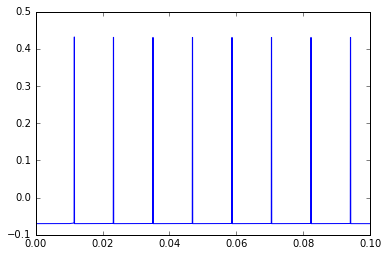

In [5]:
plot(statemon4.t,np.transpose(statemon4.v))

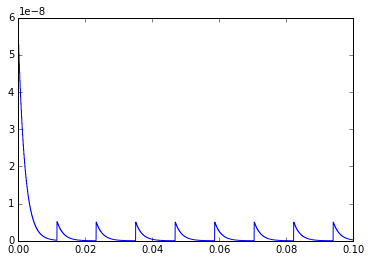

In [6]:
plot(statemon4.t,np.transpose(statemon4.ge))

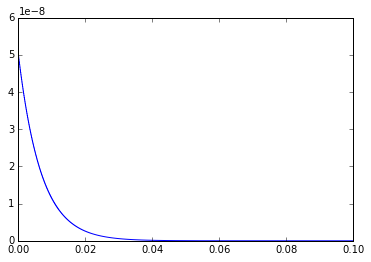

In [7]:
plot(statemon4.t,np.transpose(statemon4.gi))

In [8]:
scheduling_summary()

object,part of,Clock dt,when,order,active
statemonitor (StateMonitor),statemonitor (StateMonitor),100. us (every 10 steps),start,0,yes
statemonitor_1 (StateMonitor),statemonitor_1 (StateMonitor),10. us (every step),start,0,yes
neurongroup_3_stateupdater (StateUpdater),neurongroup_3 (NeuronGroup),100. us (every 10 steps),groups,0,yes
neurongroup_4_stateupdater (StateUpdater),neurongroup_4 (NeuronGroup),100. us (every 10 steps),groups,0,yes
neurongroup_3_thresholder (Thresholder),neurongroup_3 (NeuronGroup),100. us (every 10 steps),thresholds,0,yes
neurongroup_4_thresholder (Thresholder),neurongroup_4 (NeuronGroup),100. us (every 10 steps),thresholds,0,yes
spikemonitor (SpikeMonitor),spikemonitor (SpikeMonitor),100. us (every 10 steps),thresholds,1,yes
spikemonitor_1 (SpikeMonitor),spikemonitor_1 (SpikeMonitor),100. us (every 10 steps),thresholds,1,yes
synapses_pre (SynapticPathway),synapses (Synapses),100. us (every 10 steps),synapses,-1,yes
neurongroup_3_resetter (Resetter),neurongroup_3 (NeuronGroup),100. us (every 10 steps),resets,0,yes


In [9]:
spikemon3.spike_trains()

{0: array([  0. ,  11.5,  23.2,  35. ,  46.8,  58.6,  70.4,  82.2,  94. ]) * msecond}

In [10]:
spikemon4.spike_trains()

{0: array([  0. ,  11.6,  23.3,  35.1,  46.9,  58.7,  70.5,  82.3,  94.1]) * msecond}

In [11]:
G3.I

<neurongroup_3.I: array([ 1.]) * namp>

In [12]:
G4.I

<neurongroup_4.I: array([ 10.]) * pamp>

In [13]:
statemon3.gi[0][-10:-1]

array([ 21.45363809,  21.13814341,  20.82728836,  20.52100471,
        20.21922523,  19.92188368,  19.6289148 ,  19.34025429,  19.05583878]) * fsiemens